# Projet cooperative optimization

## Partie I

In [1]:
# import useful modules and data
import pickle
from Centralized_solution import solve, plot_me, Cov2, Cov
import numpy as np
from DGD import DGD
from GT import GT
from Dual_decomposition import dual_decomposition
from ADMM import ADMM
from visualisation import make_gap_graph, make_reconstruction_graph
import matplotlib.pyplot as plt
with open('data/first_database.pkl', 'rb') as f:
   x,y = pickle.load(f)

C:\Users\noeca\AppData\Local\Temp\ipykernel_14028\348772345.py:12: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.numeric._frombuffer.
  x,y = pickle.load(f)


### Decentralized gradient descent

In [2]:
# Parameters
num_points = 100
a = 5 # number of agents
W = np.ones([a,a])/a # consensus matrix (fully connected graph) TO BE MODIFIED for other topologies

In [3]:
## DATA PREPARATION
x = x[:num_points]
y = y[:num_points]
alpha, ind = solve(x[:num_points],y[:num_points], selection=True)
n = len(x)
m = int(np.sqrt(n))
x2 = [x[i] for i in ind] # subset M of the data points
K_nm = Cov2(x, x2) # kernel matrix between the data points and the subset M
K_mm = Cov(x2) # kernel matrix between the subset M
points_per_agent = n // a # number of data points per agent
indices = np.random.permutation(n) # random permutation of the data points to be distributed among the agents
K_a = [K_nm[indices[i*points_per_agent:(i+1)*points_per_agent], :] for i in range(a)]
y_a = [y[indices[i*points_per_agent:(i+1)*points_per_agent]] for i in range(a)]

In [4]:
# Initialization and parameters of DGD
alpha_0 = np.zeros((a,m)) # Initialization of the local variables for each agent
n_iter = 50000
step_size = 0.001

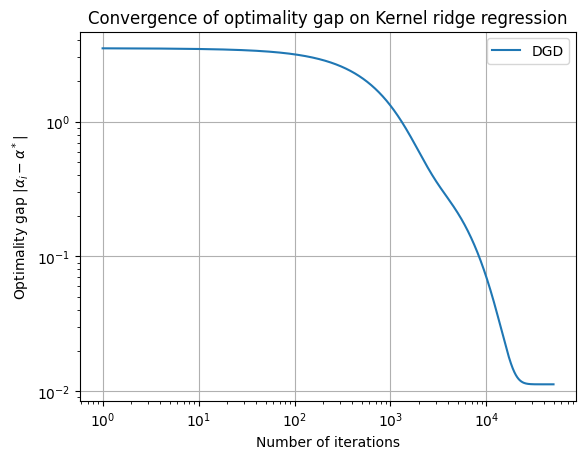

In [5]:
alpha_dgd = DGD(alpha_0, K_a, K_mm, y_a, W, sigma=0.5, nu=1.0, max_iter=n_iter, lr=step_size)
opt_gap = [np.linalg.norm(alpha_i - alpha) for alpha_i in alpha_dgd]
plt.loglog(np.arange(1,len(opt_gap)+1), opt_gap, label="DGD")
plt.xlabel('Number of iterations')
plt.ylabel(r'Optimality gap $|\alpha_i - \alpha^*|$')
plt.title('Convergence of optimality gap on Kernel ridge regression')
plt.grid()
plt.legend()
plt.show()

### Gradient tracking

In [6]:
# Initialization and parameters of Gradient Tracking
alpha_0 = np.zeros((a,m)) # Initialization of the local variables for each agent
n_iter = 50000
step_size = 0.001

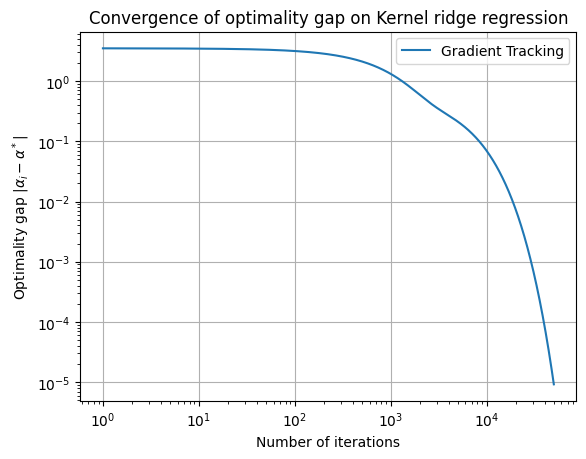

In [7]:
alpha_gt = GT(alpha_0, K_a, K_mm, y_a, W, sigma=0.5, nu=1.0, max_iter=n_iter, lr=step_size)
opt_gap = [np.linalg.norm(alpha_i - alpha) for alpha_i in alpha_gt]
plt.loglog(np.arange(1,len(opt_gap)+1), opt_gap, label="Gradient Tracking")
plt.xlabel('Number of iterations')
plt.ylabel(r'Optimality gap $|\alpha_i - \alpha^*|$')
plt.title('Convergence of optimality gap on Kernel ridge regression')
plt.grid()
plt.legend()
plt.show()

### Dual decomposition (peer to peer)

In [8]:
# Intialization
A = np.ones([a,a])- np.eye(a) 
multipliers_0 = np.zeros([int(np.sum(A)/2),m]) # Initialization of the multipliers for dual decomposition
n_iter = 50000
step_size = 0.01


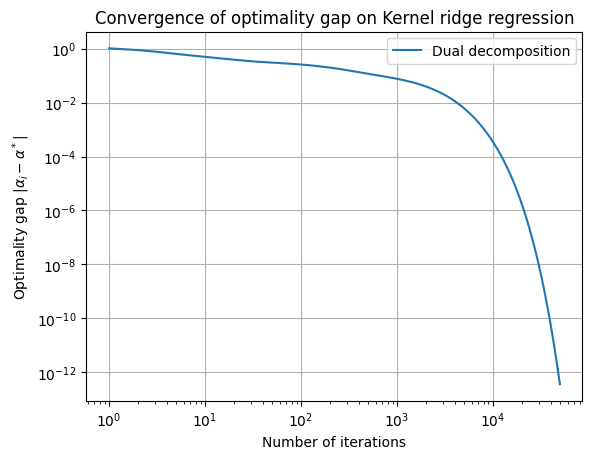

In [9]:
alpha_dualdecomp, multipliers = dual_decomposition(multipliers_0, K_a, K_mm, y_a, np.ones([a, a]), sigma=0.5, nu=1.0, max_iter=n_iter, lr=step_size)   
opt_gap = [np.linalg.norm(alpha_i - alpha) for alpha_i in alpha_dualdecomp]
plt.loglog(np.arange(1,len(opt_gap)+1), opt_gap, label="Dual decomposition")
plt.xlabel('Number of iterations')
plt.ylabel(r'Optimality gap $|\alpha_i - \alpha^*|$')
plt.title('Convergence of optimality gap on Kernel ridge regression')
plt.grid()
plt.legend()
plt.show()

In [10]:
# Intialization
A = np.ones([a,a])- np.eye(a) 
multipliers_0 = np.zeros((m*int(np.sum(A)/2,))) # Initialization of the multipliers for dual decomposition
n_iter = 50000
step_size = 1

## ADMM


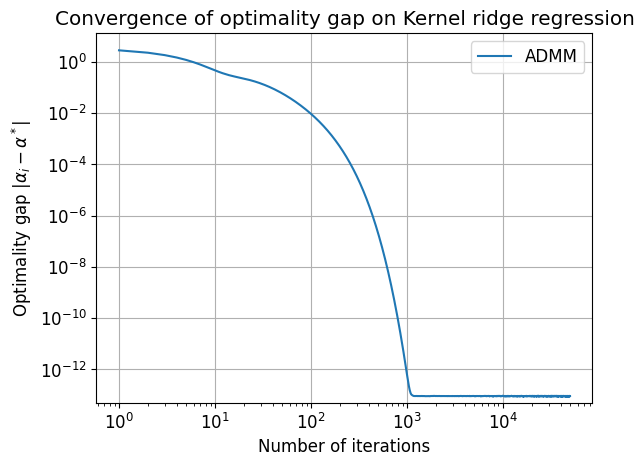

In [22]:
# Intialization
A = np.ones([a,a])- np.eye(a) 
multipliers_0 = np.zeros([int(np.sum(A)/2),m]) # Initialization of the multipliers for dual decomposition
n_iter = 50000
egalizers_0 = np.zeros((int(np.sum(A)/2),m)) # Initialization of the egalizers for dual decomposition
step_size = 1
alpha_admm, multipliers_admm = ADMM(multipliers_0, egalizers_0, beta=1, K_a=K_a, K_mm=K_mm, y_a=y_a, A=np.ones([a,a])-np.eye(a), sigma=0.5, nu=1.0, max_iter=n_iter)
make_gap_graph(alpha, {'ADMM': alpha_admm},pdf=False,precisionlimit=5e-14)

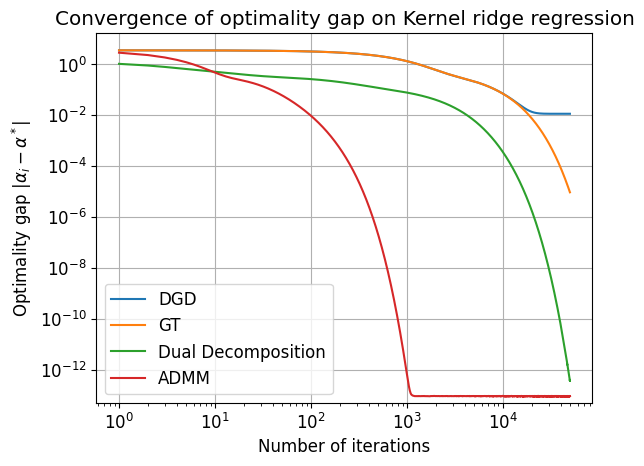

In [21]:
alphaDict = {'DGD': alpha_dgd, 'GT': alpha_gt, 'Dual Decomposition': alpha_dualdecomp, 'ADMM': alpha_admm}

#make_reconstruction_graph(x[:num_points],y[:num_points], alpha, alpha_dgd[-1], ind, selection=True, n_iter=n_iter, method_name="DGD", nt=250, agent_index=0)
make_gap_graph(alpha, alphaDict,pdf=False,precisionlimit=5e-14)